## The Dawid-Skene model with priors: BEERS

In [2]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/Users/visenger/Library/Jupyter


In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix

In [187]:
#read data from csv
#header: num, annotator-id, y, label

#BEERS
init_data = pd.read_csv("data/beers-dawid-skene.csv")
init_data.head()


,num,annotator-id,y,label
0,94,0,0,0
1,94,1,0,0
2,94,2,1,0
3,94,6,1,0
4,708,0,0,0


In [189]:
I = 500              # number of items
tmp_data = init_data.loc[init_data["num"]<I]

data = tmp_data.head(I)
z_true = np.asarray(data["label"].values)

J_num= np.unique(np.asarray(data["annotator-id"].values))
print(J_num)
J = J_num.size      # number of annotators
K = 2               # number of classes: clean (0) or error (1) 
N = I * J

[0 1 2 3 4 5 6]


In [75]:
#data.loc[data["label"]==1].count()

In [76]:
# create data triplets
jj = list(np.asarray(data["annotator-id"].values))  # annotator IDs
ii = list(np.asarray(data["num"].values))           # item IDs
y = list(np.asarray(data["y"].values))              # response


In [192]:
f_majority_vote = lambda x: np.bincount(np.array( x )).argmax()
data["majority-vote"] = data.groupby("num")["y"].transform(f_majority_vote)

f_at_least_one_vote = lambda x: np.bincount(np.array(x)).argmin()
data["min-1"] = data.groupby("num")["y"].transform(f_at_least_one_vote)

data.head()

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,num,annotator-id,y,label,majority-vote,min-1
0,94,0,0,0,0,0
1,94,1,0,0,0,0
2,94,2,1,0,0,0
3,94,6,1,0,0,0
403,68,0,0,0,0,1


Confusion matrix in binary classification, the count of true negatives is
$C_{0,0}$, false negatives is $C_{1,0}$, true positives is
$C_{1,1}$ and false positives is $C_{0,1}$.

In [193]:
z_majority_vote = np.asarray(data["majority-vote"].values)

confMat_majority_vote = confusion_matrix( z_true, z_majority_vote )
print( "Majority vote estimate of true category:\n" , confMat_majority_vote )

Majority vote estimate of true category:
 [[461   3]
 [ 36   0]]


In [194]:
z_min_1 =np.asarray(data["min-1"].values)

confMat_min_1 = confusion_matrix( z_true, z_min_1 )
print( "Min-1 estimate of true category:\n" , confMat_min_1 )

Min-1 estimate of true category:
 [[124 340]
 [  8  28]]


In [80]:
# class prevalence (flat prior)
alpha = np.ones( K )

# individual annotator confusion matrices - dominant diagonal
beta = np.ones( (K,K) ) + np.diag( np.ones(K) )

In [82]:
#z_init = np.asarray(data["majority-vote"].values)
z_init = np.asarray(data["min-1"].values)

model = pm.Model()

with model:
    pi = pm.Dirichlet( 'pi', a=alpha, shape=K )
    theta = pm.Dirichlet( 'theta', a=beta, shape=(J,K,K) )
    z = pm.Categorical( 'z', p=pi, shape=I, testval=z_init )
    y_obs = pm.Categorical( 'y_obs', p=theta[ jj, z[ ii ] ], observed=y )

/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [83]:
with model:
    step1 = pm.Metropolis( vars=[pi,theta] )
    step2 = pm.CategoricalGibbsMetropolis( vars=[z] )
    trace = pm.sample( 5000, step=[step1, step2], progressbar=True )


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [theta]
>>Metropolis: [pi]
>CategoricalGibbsMetropolis: [z]
Sampling 4 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/pyth

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13edd2390>,
      dtype=object)

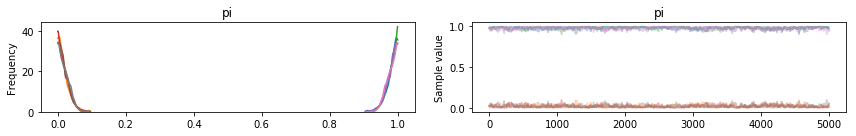

In [84]:
pm.traceplot( trace, varnames=['pi'] )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1262572e8>,
      dtype=object)

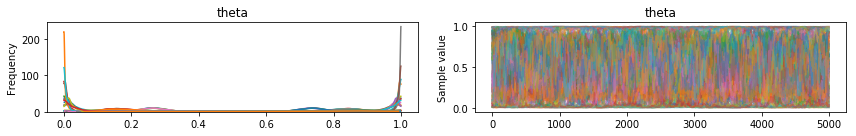

In [85]:
pm.traceplot( trace, varnames=['theta'] )

In [86]:
#to long
#pm.traceplot( trace, varnames=['z'] )

In [17]:
#error:
#pm.traceplot( trace, varnames=['y_obs'] )

In [171]:
#for n in range(100, 10000, 100):
n=300
z = trace['z'][-n:,:]
z_hat = np.zeros( I )

for i in range( I ):
    z_hat[ i ] = np.bincount( z[:,i] ).argmin()
    
unique, counts = np.unique(z_hat, return_counts=True)    
print("number of samples:", n)
print(np.asarray((unique, counts)).T)

number of samples: 300
[[  0. 108.]
 [  1. 392.]]


In [195]:
def f1(confMat):
    tn=confMat[0][0]
    fp=confMat[0][1]
    fn=confMat[1][0]
    tp=confMat[1][1]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_1= 2*precision*recall/(precision+recall)
    print('Precision: %0.4f, Recall: %0.4f, F-1: %0.4f'% (precision, recall, f_1))

In [196]:
#trace['z'].shape

In [197]:
confMat = confusion_matrix( z_true, z_hat )
print( "Dawid-Skene estimate of true category:\n", confMat )

f1(confMat)

print("Majority wins:")
f1(confMat_majority_vote)
print("Min-1:")
f1(confMat_min_1)

Dawid-Skene estimate of true category:
 [[ 99 365]
 [  9  27]]
Precision: 0.0689, Recall: 0.7500, F-1: 0.1262
Majority wins:
Precision: 0.0000, Recall: 0.0000, F-1: nan
Min-1:
Precision: 0.0761, Recall: 0.7778, F-1: 0.1386


1 Variant: for training model, z_init is majority vote: Dawid-Skene estimate of true category:

 [[464   0]
 
 [ 36   0]]
 
 
2 Variant: for training model, z_init is min-1:
Dawid-Skene estimate of true category:

 [[461   3]
 
 [ 36   0]]

In [174]:
np.set_printoptions(precision=2)
for j in range( J ):
    print( "Annotator j=" + str(j) )
    Cj = trace['theta'][-1,j]
    print( Cj )

Annotator j=0
[[0.98 0.02]
 [0.73 0.27]]
Annotator j=1
[[9.99e-01 9.79e-04]
 [5.39e-01 4.61e-01]]
Annotator j=2
[[0.22 0.78]
 [0.92 0.08]]
Annotator j=3
[[0.9  0.1 ]
 [0.04 0.96]]
Annotator j=4
[[0.28 0.72]
 [0.04 0.96]]
Annotator j=5
[[0.97 0.03]
 [0.35 0.65]]
Annotator j=6
[[0.44 0.56]
 [0.13 0.87]]


The best annotator:
Annotator j=3
[[0.9  0.1 ]
 [0.04 0.96]]

In [198]:
#investigating annotator j=3:
#j=2

for j in range (0, J):
    annotator_data=init_data.loc[init_data["annotator-id"]==j]
    y_annotator= np.asarray(annotator_data["y"].values)
    true_label = np.asarray(annotator_data["label"].values)
    annotator_conf_matrix = confusion_matrix( true_label, y_annotator )
    print( "annotator estimate of true category:\n" ,j, annotator_conf_matrix )
    f1(annotator_conf_matrix)

annotator estimate of true category:
 0 [[23172   880]
 [ 2331   127]]
Precision: 0.1261, Recall: 0.0517, F-1: 0.0733
annotator estimate of true category:
 1 [[23172     0]
 [ 2139   192]]
Precision: 1.0000, Recall: 0.0824, F-1: 0.1522
annotator estimate of true category:
 2 [[ 5645 17527]
 [ 1109  1222]]
Precision: 0.0652, Recall: 0.5242, F-1: 0.1159
annotator estimate of true category:
 3 [[8971    0]
 [   0 2204]]
Precision: 1.0000, Recall: 1.0000, F-1: 1.0000
annotator estimate of true category:
 4 [[   0 1874]
 [   0  205]]
Precision: 0.0986, Recall: 1.0000, F-1: 0.1795
annotator estimate of true category:
 5 [[4470   96]
 [   0  254]]
Precision: 0.7257, Recall: 1.0000, F-1: 0.8411
annotator estimate of true category:
 6 [[ 0 33]
 [ 0  1]]
Precision: 0.0294, Recall: 1.0000, F-1: 0.0571


In [190]:
labels = np.asarray(init_data["label"].values)
unique, counts = np.unique(labels, return_counts=True)    

print(np.asarray((unique, counts)).T)

[[    0 85840]
 [    1  9784]]
